# American Express Default Prediction

### Competition Objective:

American Express is a globally integrated payments company. The largest payment card issuer in the world, they provide customers with access to products, insights, and experiences that enrich lives and build business success.

Credit default prediction is central to managing risk in a consumer lending business. The objective of is to predict the probability that a customer does not pay back their credit card balance amount in the future based on their monthly customer profile.

### Data Overview:

The target binary variable is calculated by observing 18 months performance window after the latest credit card statement, and if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.

The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

**`D_*`:** Delinquency variables  
**`S_*`:** Spend variables  
**`P_*`:** Payment variables  
**`B_*`:** Balance variables  
**`R_*`:** Risk variables

With the following features being categorical: `B_30`, `B_38`, `D_63`, `D_64`, `D_66`, `D_68`, `D_114`, `D_116`, `D_117`, `D_120`, `D_126`.


In [ ]:
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import gc

In [1]:
# Loading the Data

# The data has been stored in a compressed feather file to reduce memory.
train = pd.read_feather("train_data.ftr")
train = train.groupby("customer_ID").tail(1).set_index("customer_ID")
print(
    "The training data begins on {} and ends on {}.".format(
        train["S_2"].min().strftime("%m-%d-%Y"), train["S_2"].max().strftime("%m-%d-%Y")
    )
)
print(
    "There are {:,.0f} customers in the training set and {} features.".format(
        train.shape[0], train.shape[1]
    )
)

test = pd.read_feather("../input/amexfeather/test_data.ftr")
test = test.groupby("customer_ID").tail(1).set_index("customer_ID")
print(
    "\nThe test data begins on {} and ends on {}.".format(
        test["S_2"].min().strftime("%m-%d-%Y"), test["S_2"].max().strftime("%m-%d-%Y")
    )
)
print(
    "There are {:,.0f} customers in the test set and {} features.".format(
        test.shape[0], test.shape[1]
    )
)

# The features have been annonymized
# Renaming them for better readability

titles = [
    "Delinquency " + str(i).split("_")[1]
    if i.startswith("D")
    else "Spend " + str(i).split("_")[1]
    if i.startswith("S")
    else "Payment " + str(i).split("_")[1]
    if i.startswith("P")
    else "Balance " + str(i).split("_")[1]
    if i.startswith("B")
    else "Risk " + str(i).split("_")[1]
    for i in train.columns[:-1]
]
cat_cols = [
    "Balance 30",
    "Balance 38",
    "Delinquency 63",
    "Delinquency 64",
    "Delinquency 66",
    "Delinquency 68",
    "Delinquency 114",
    "Delinquency 116",
    "Delinquency 117",
    "Delinquency 120",
    "Delinquency 126",
    "Target",
]
test.columns = titles[1:]
titles.append("Target")
train.columns = titles


The training data begins on 03-01-2018 and ends on 03-31-2018.
There are 458,913 customers in the training set and 190 features.

The test data begins on 04-01-2019 and ends on 10-31-2019.
There are 924,621 customers in the test set and 189 features.


In the training set, the last statement of all customers was in March 2018, while in the test set the date of customers' last statements range from April through October 2019. 

### Exploratory Data Analysis:

#### Checking for Class Imbalance:

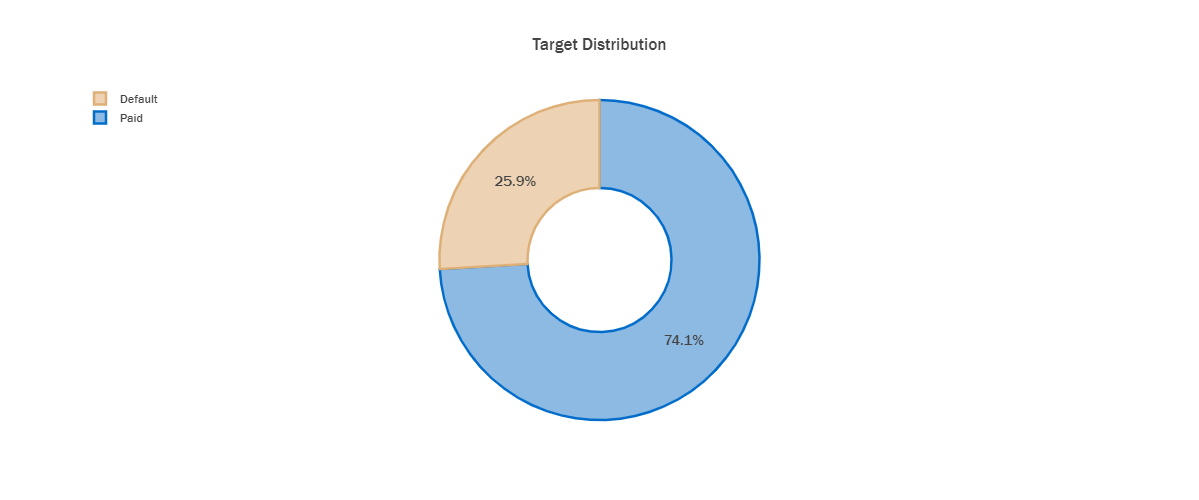

In [2]:
# Checking the distribution of target variable
target = train.Target.value_counts(normalize=True)
target.rename(index={1: "Default", 0: "Paid"}, inplace=True)
pal, color = ["#016CC9", "#DEB078"], ["#8DBAE2", "#EDD3B3"]
fig = go.Figure()
fig.add_trace(
    go.Pie(
        labels=target.index,
        values=target * 100,
        hole=0.45,
        showlegend=True,
        sort=False,
        marker=dict(colors=color, line=dict(color=pal, width=2.5)),
        hovertemplate="%{label} Accounts: %{value:.2f}%<extra></extra>",
    )
)
fig.update_layout(
    template=temp,
    title="Target Distribution",
    legend=dict(traceorder="reversed", y=1.05, x=0),
    uniformtext_minsize=15,
    uniformtext_mode="hide",
    width=700,
)
fig.show()


#### Observing Distribution of Default per day for the first Month

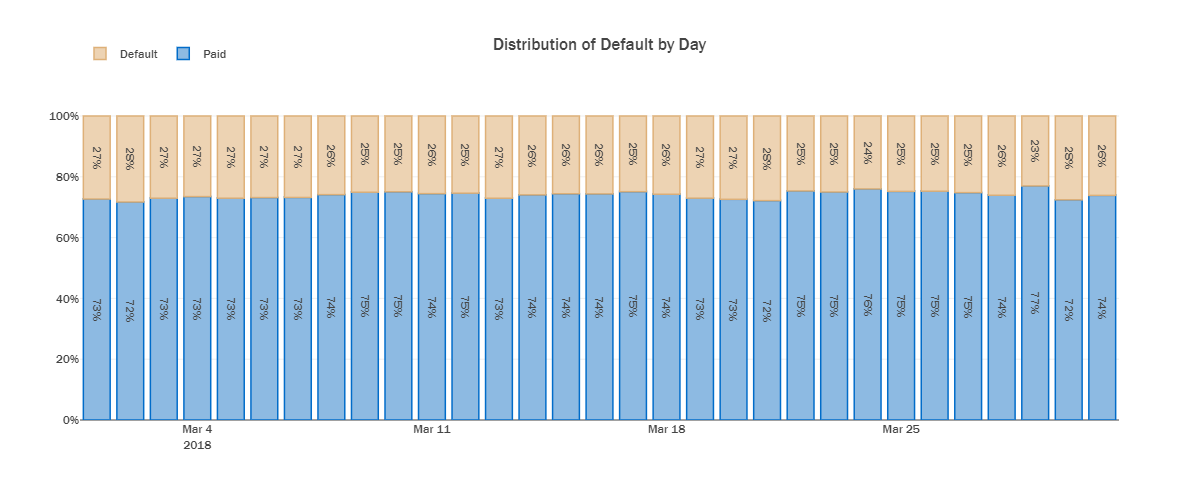

In [3]:
target = pd.DataFrame(data={"Default": train.groupby("Spend 2")["Target"].mean() * 100})
target["Paid"] = np.abs(train.groupby("Spend 2")["Target"].mean() - 1) * 100
rgb = ["rgba" + str(matplotlib.colors.to_rgba(i, 0.7)) for i in pal]
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=target.index,
        y=target.Paid,
        name="Paid",
        text=target.Paid,
        texttemplate="%{text:.0f}%",
        textposition="inside",
        insidetextanchor="middle",
        marker=dict(color=color[0], line=dict(color=pal[0], width=1.5)),
        hovertemplate="<b>%{x}</b><br>Paid accounts: %{y:.2f}%",
    )
)
fig.add_trace(
    go.Bar(
        x=target.index,
        y=target.Default,
        name="Default",
        text=target.Default,
        texttemplate="%{text:.0f}%",
        textposition="inside",
        insidetextanchor="middle",
        marker=dict(color=color[1], line=dict(color=pal[1], width=1.5)),
        hovertemplate="<b>%{x}</b><br>Default accounts: %{y:.2f}%",
    )
)
fig.update_layout(
    template=temp,
    title="Distribution of Default by Day",
    barmode="relative",
    yaxis_ticksuffix="%",
    width=1400,
    legend=dict(
        orientation="h",
        traceorder="reversed",
        yanchor="bottom",
        y=1.1,
        xanchor="left",
        x=0,
    ),
)
fig.show()


About 25% of customers in the training data have defaulted. This proportion is consistent across each day in the training set, with a weekly seasonal trend in the day of the month when customers receive their statements.

#### Frequency of Customer Statements for the first month

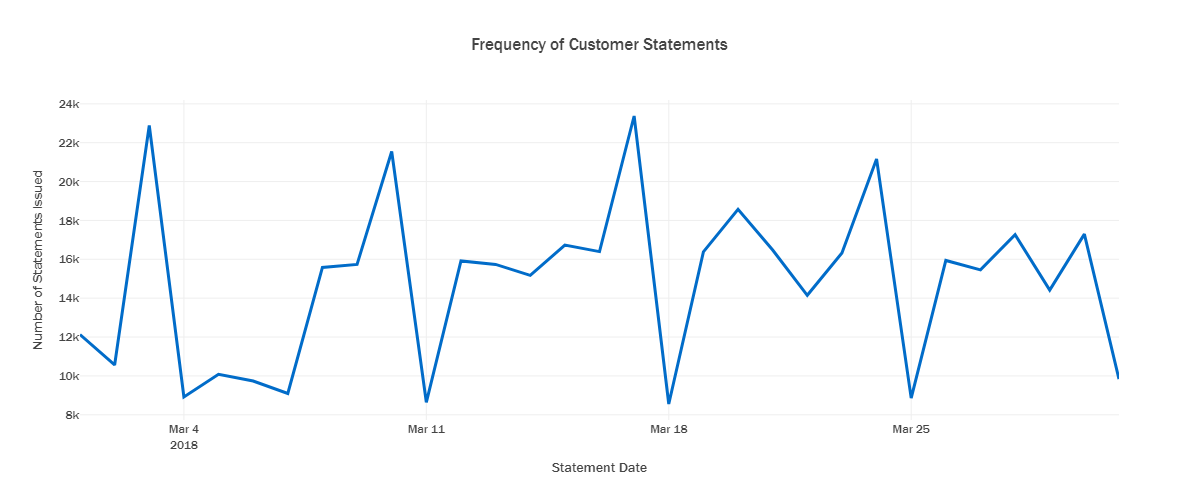

In [4]:
plot_df = train.reset_index().groupby("Spend 2")["customer_ID"].nunique().reset_index()
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=plot_df["Spend 2"],
        y=plot_df["customer_ID"],
        mode="lines",
        line=dict(color=pal[0], width=3),
        hovertemplate="",
    )
)
fig.update_layout(
    template=temp,
    title="Frequency of Customer Statements",
    hovermode="x unified",
    width=800,
    height=500,
    xaxis_title="Statement Date",
    yaxis_title="Number of Statements Issued",
)
fig.show()
del train["Spend 2"]


#### Features with Highest Percentage of Missing Values

In [ ]:
null = round((train.isna().sum() / train.shape[0] * 100), 2).sort_values(
    ascending=False
).astype(str) + ("%")
null = null.to_frame().rename(columns={0: "Missing %"})
null.head(30)

Missing %
Delinquency 87     99.86%
Delinquency 88     99.82%
Delinquency 108    99.43%
Delinquency 111     99.2%
Delinquency 110     99.2%
Balance 39         99.11%
Delinquency 73     99.08%
Balance 42         98.66%
Delinquency 136    96.43%
Delinquency 135    96.43%
Delinquency 134    96.43%
Delinquency 137    96.43%
Delinquency 138    96.43%
Risk 9             94.13%
Balance 29         94.05%
Delinquency 76     89.25%
Risk 26            88.86%
Delinquency 106    88.75%
Delinquency 132    88.72%
Delinquency 49     88.72%
Delinquency 66     88.54%
Delinquency 42     86.95%
Delinquency 142     82.5%
Delinquency 82     74.81%
Delinquency 53     71.02%
Delinquency 50     57.14%
Delinquency 105    53.52%
Delinquency 56     53.33%
Balance 17         53.27%
Delinquency 77      46.6%

#### Checking Correlation of Features with Target Variable

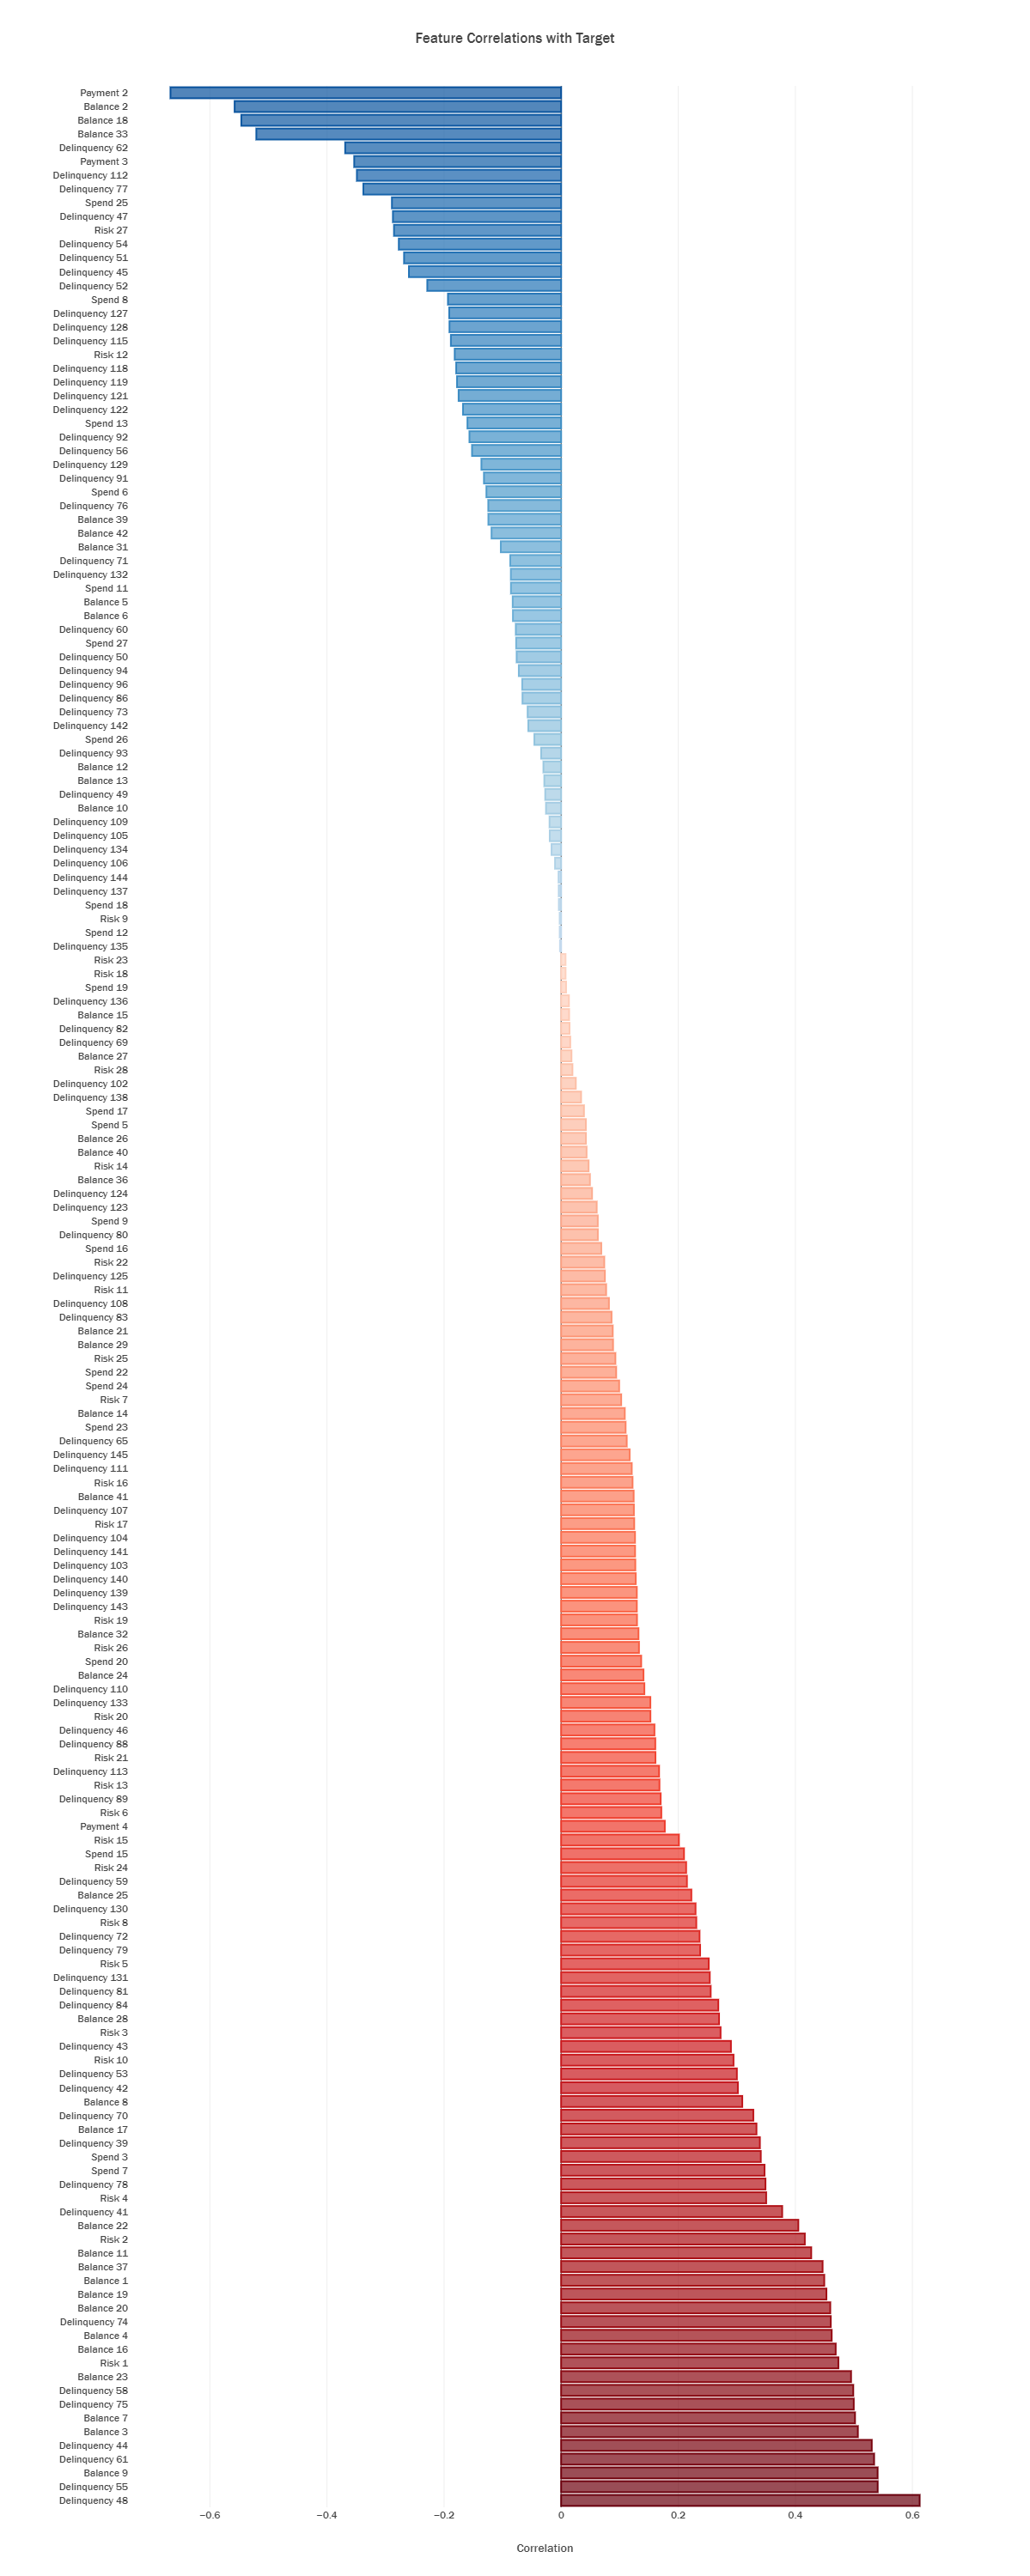

In [ ]:
corr = train.corr()
corr = corr["Target"].sort_values(ascending=False)[1:-1]
pal = sns.color_palette("Reds_r", 135).as_hex()
rgb = ["rgba" + str(matplotlib.colors.to_rgba(i, 0.7)) for i in pal]
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=corr[corr >= 0],
        y=corr[corr >= 0].index,
        marker_color=rgb,
        orientation="h",
        marker_line=dict(color=pal, width=2),
        name="",
        hovertemplate="%{y} correlation with target: %{x:.3f}",
        showlegend=False,
    )
)
pal = sns.color_palette("Blues", 100).as_hex()
rgb = ["rgba" + str(matplotlib.colors.to_rgba(i, 0.7)) for i in pal]
fig.add_trace(
    go.Bar(
        x=corr[corr < 0],
        y=corr[corr < 0].index,
        marker_color=rgb[25:],
        orientation="h",
        marker_line=dict(color=pal[25:], width=2),
        name="",
        hovertemplate="%{y} correlation with target: %{x:.3f}",
        showlegend=False,
    )
)
fig.update_layout(
    template=temp,
    title="Feature Correlations with Target",
    xaxis_title="Correlation",
    margin=dict(l=150),
    height=3000,
    width=700,
    hovermode="closest",
)
fig.show()


There are several strong correlations with the target variable. `Payment 2` is the most negatively correlated with the probability of defaulting with a correlation of -0.67, while `Delinquency 48` is the most positively correlated overall at 0.61. `Delinquency 87` is also missing from the correlations above due to the proportion of null values. In fact, 24 of the top 30 features with missing values are in `Delinquency` variables. 

#### Distribution of Delinquency Variables

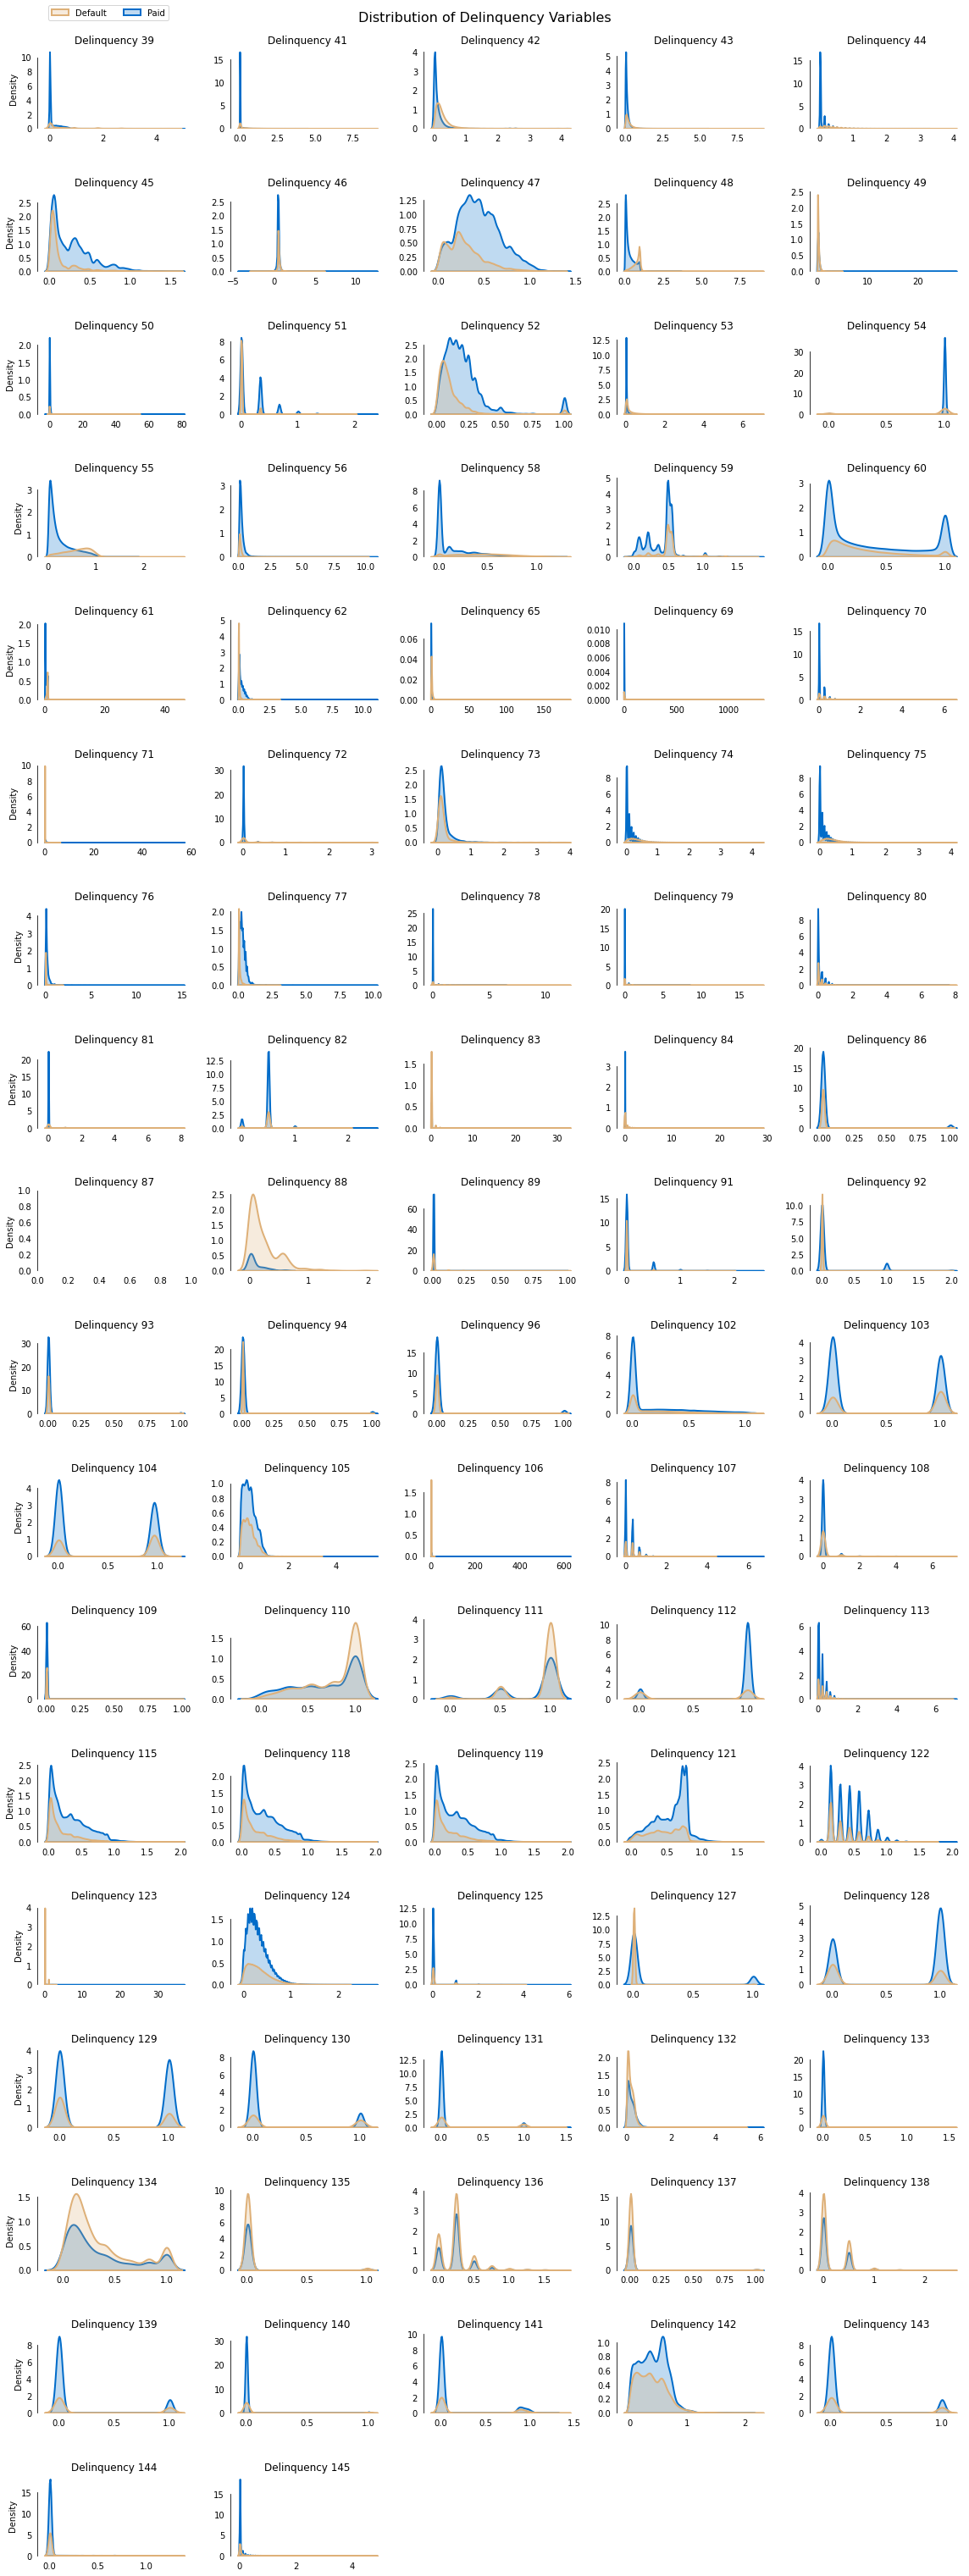

In [5]:
cols = [
    col
    for col in train.columns
    if (col.startswith(("D", "T"))) & (col not in cat_cols[:-1])
]
plot_df = train[cols]
fig, ax = plt.subplots(18, 5, figsize=(16, 54))
fig.suptitle("Distribution of Delinquency Variables", fontsize=16)
row = 0
col = [0, 1, 2, 3, 4] * 18
for i, column in enumerate(plot_df.columns[:-1]):
    if (i != 0) & (i % 5 == 0):
        row += 1
    sns.kdeplot(
        x=column,
        hue="Target",
        palette=pal[::-1],
        hue_order=[1, 0],
        label=["Default", "Paid"],
        data=plot_df,
        fill=True,
        linewidth=2,
        legend=False,
        ax=ax[row, col[i]],
    )
    ax[row, col[i]].tick_params(left=False, bottom=False)
    ax[row, col[i]].set(
        title="\n\n{}".format(column),
        xlabel="",
        ylabel=("Density" if i % 5 == 0 else ""),
    )
for i in range(2, 5):
    ax[17, i].set_visible(False)
handles, _ = ax[0, 0].get_legend_handles_labels()
fig.legend(
    labels=["Default", "Paid"],
    handles=reversed(handles),
    ncol=2,
    bbox_to_anchor=(0.18, 0.983),
)
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])


We observe that even though most varibles have continuous values between 0 and 1, most of the density is just located at either 0 or 1. This tells us that there may be some Gaussian Noise present. This can be cleaned and these variables can be converted into binary variables.

#### Correlation of Delinquency Variables

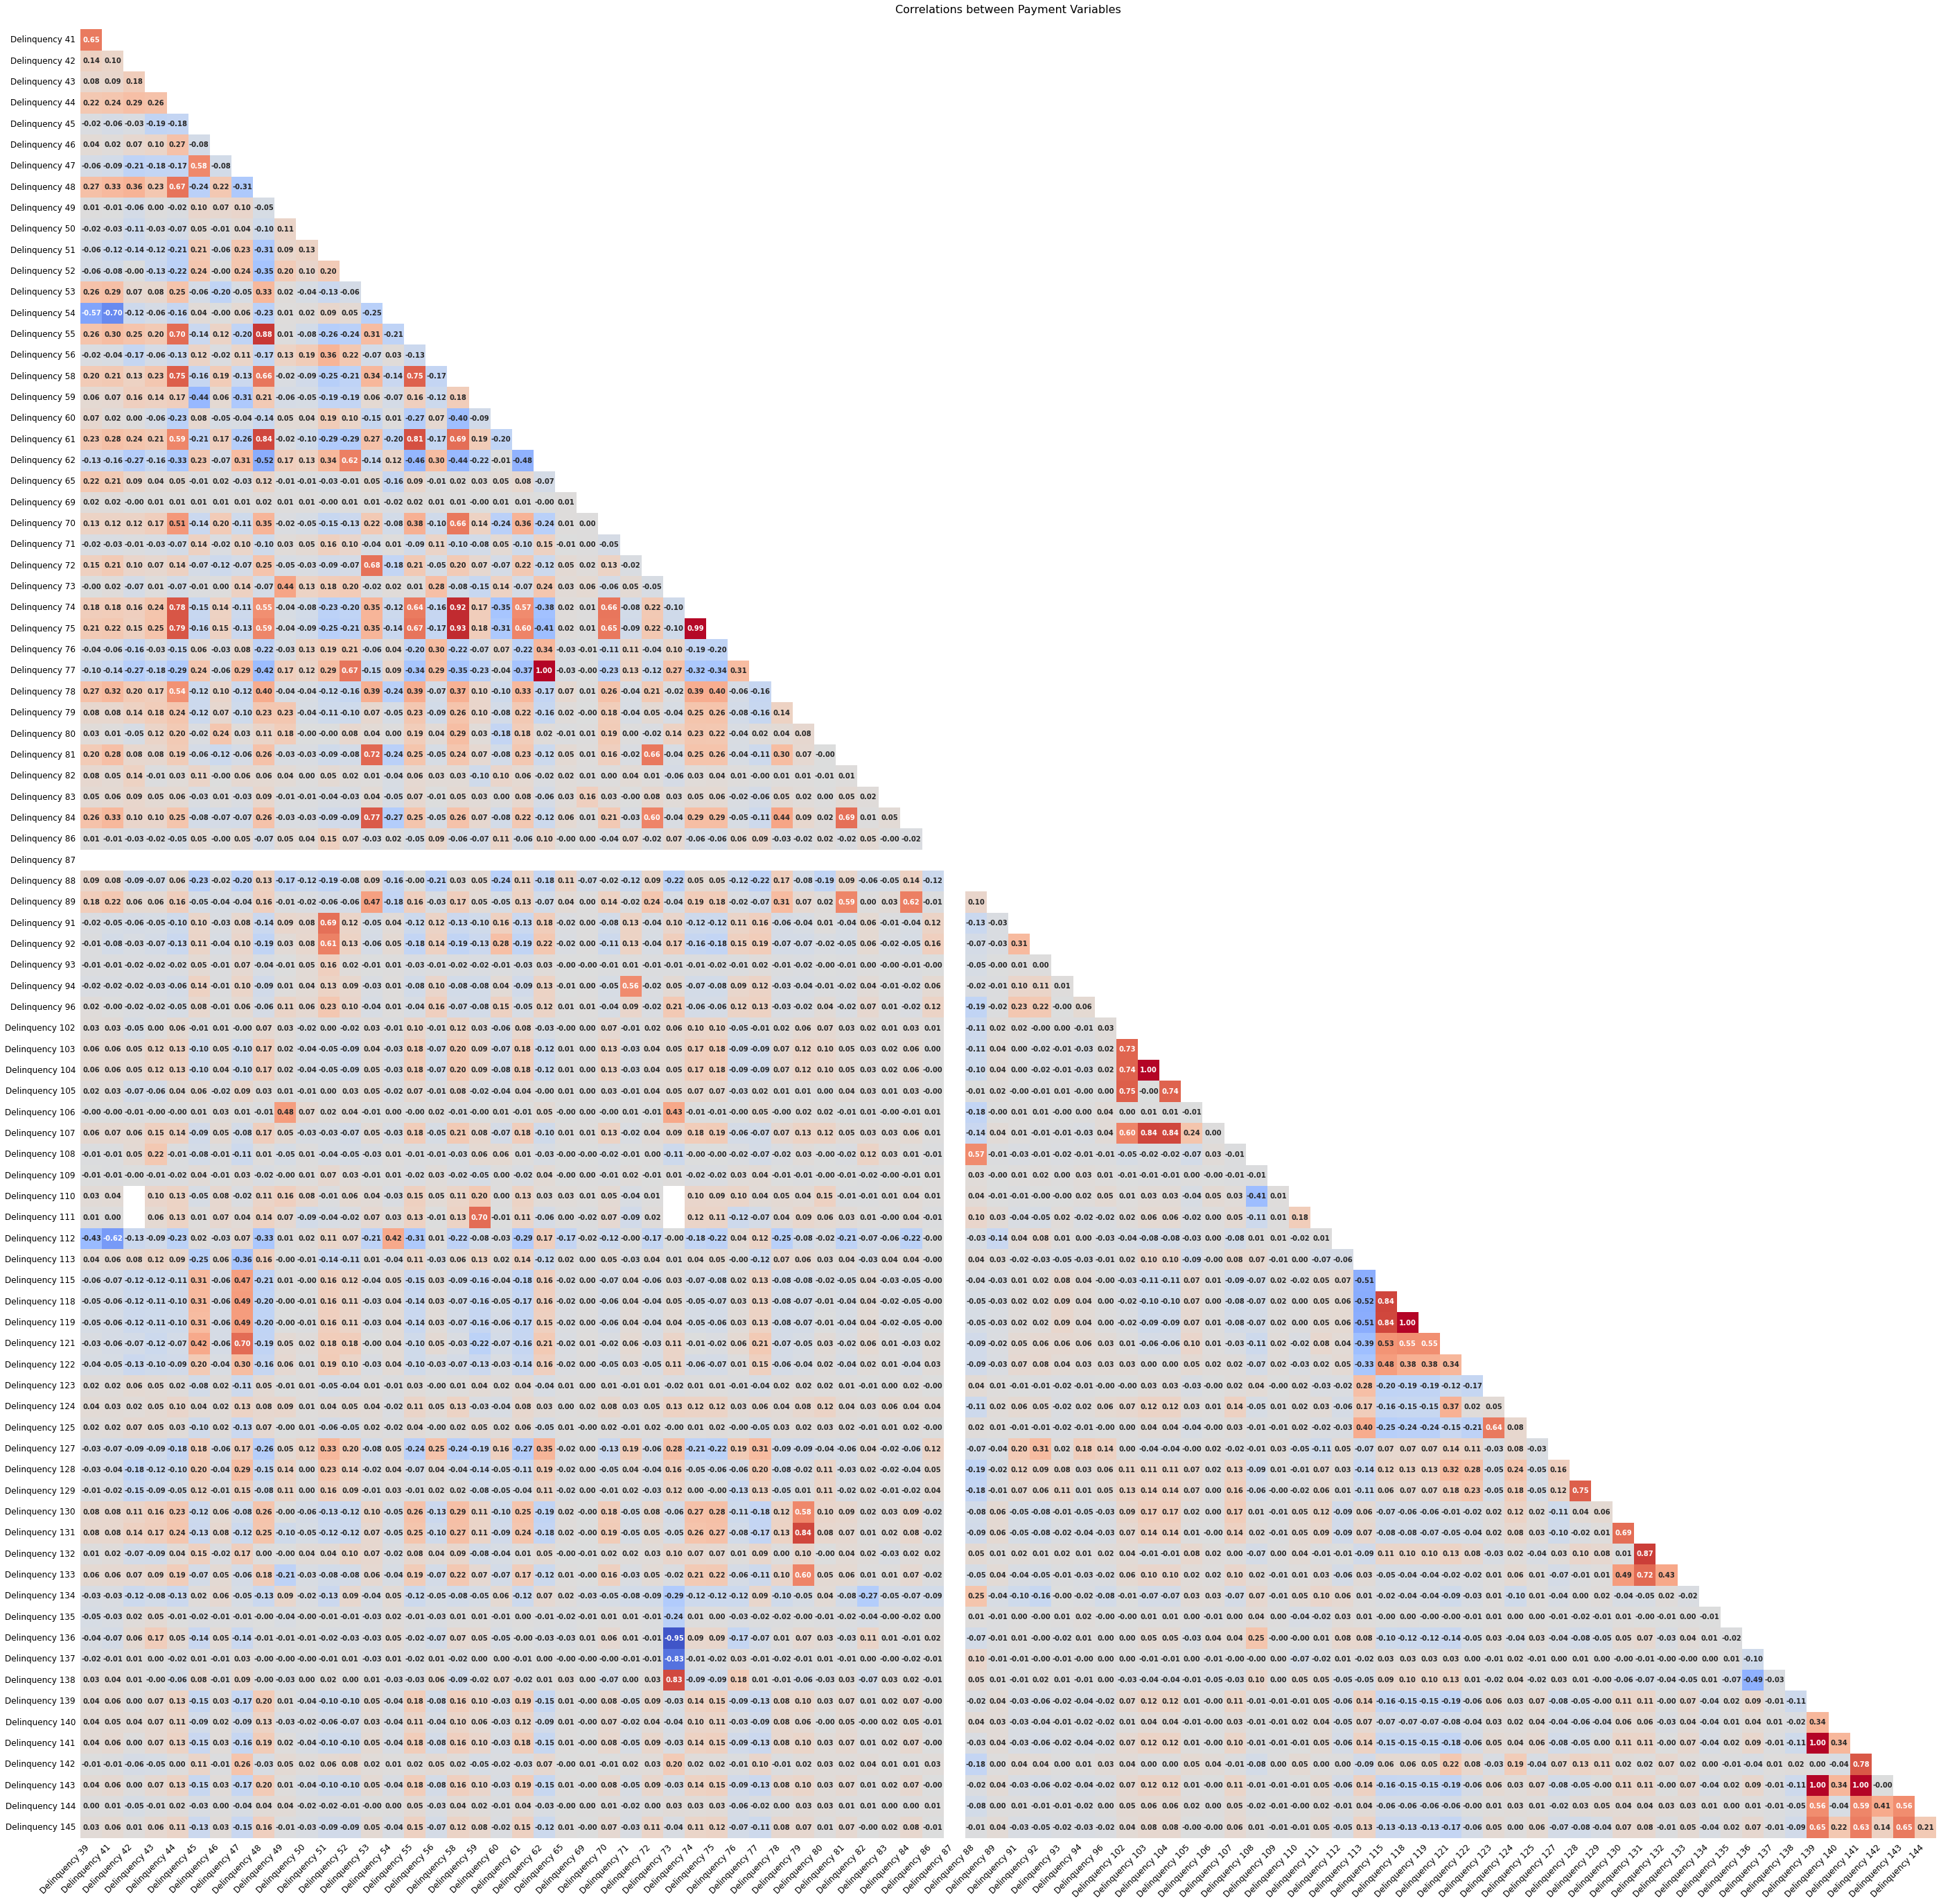

In [6]:
corr = plot_df.iloc[:, :-1].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))[1:, :-1]
corr = corr.iloc[1:, :-1].copy()
fig, ax = plt.subplots(figsize=(48, 48))
sns.heatmap(
    corr,
    mask=mask,
    vmin=-1,
    vmax=1,
    center=0,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    annot_kws={"fontsize": 10, "fontweight": "bold"},
    cbar=False,
)
ax.tick_params(left=False, bottom=False)
ax.set_xticklabels(
    ax.get_xticklabels(), rotation=45, horizontalalignment="right", fontsize=12
)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title("Correlations between Payment Variables\n", fontsize=16)
fig.show()


We find that `Delinquency 74` and `Delinquency 75` are highly correlated. They can be merged together.
`Delinquency 131` and `Delinquency 132` also seem to be highly correlated. There are also a number of missing correlations, particularly in `Delinquency 87`, due to null values in the data.

The perfectly correlated pairs can be merged using PCA if necessary. This will help reduce cardinality.

#### Distribution of Spend Variables

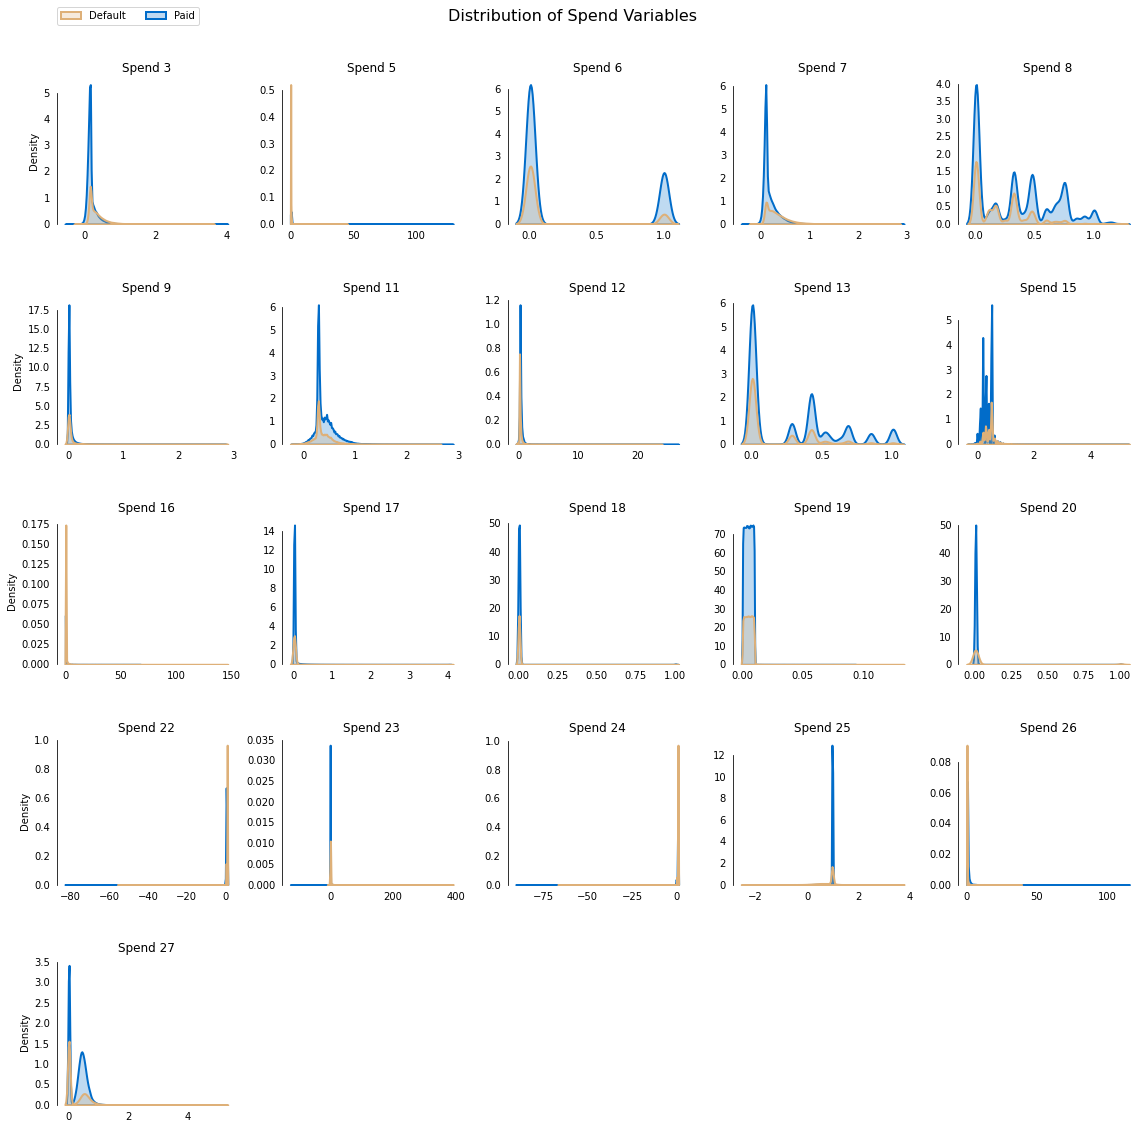

In [8]:
cols = [
    col
    for col in train.columns
    if (col.startswith(("S", "T"))) & (col not in cat_cols[:-1])
]
plot_df = train[cols]
fig, ax = plt.subplots(5, 5, figsize=(16, 20))
fig.suptitle("Distribution of Spend Variables", fontsize=16)
row = 0
col = [0, 1, 2, 3, 4] * 5
for i, column in enumerate(plot_df.columns[:-1]):
    if (i != 0) & (i % 5 == 0):
        row += 1
    sns.kdeplot(
        x=column,
        hue="Target",
        palette=pal[::-1],
        hue_order=[1, 0],
        label=["Default", "Paid"],
        data=plot_df,
        fill=True,
        linewidth=2,
        legend=False,
        ax=ax[row, col[i]],
    )
    ax[row, col[i]].tick_params(left=False, bottom=False)
    ax[row, col[i]].set(
        title="\n\n{}".format(column),
        xlabel="",
        ylabel=("Density" if i % 5 == 0 else ""),
    )
for i in range(1, 5):
    ax[4, i].set_visible(False)
handles, _ = ax[0, 0].get_legend_handles_labels()
fig.legend(
    labels=["Default", "Paid"],
    handles=reversed(handles),
    ncol=2,
    bbox_to_anchor=(0.18, 0.985),
)
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])


Similar to Delinquency Variables, we observe that even though most varibles have continuous values between 0 and 1, most of the density is just located at either 0 or 1. This tells us that there may be some Gaussian Noise present. This can be cleaned and these variables can be converted into binary variables.

#### Correlation of Spend Variables

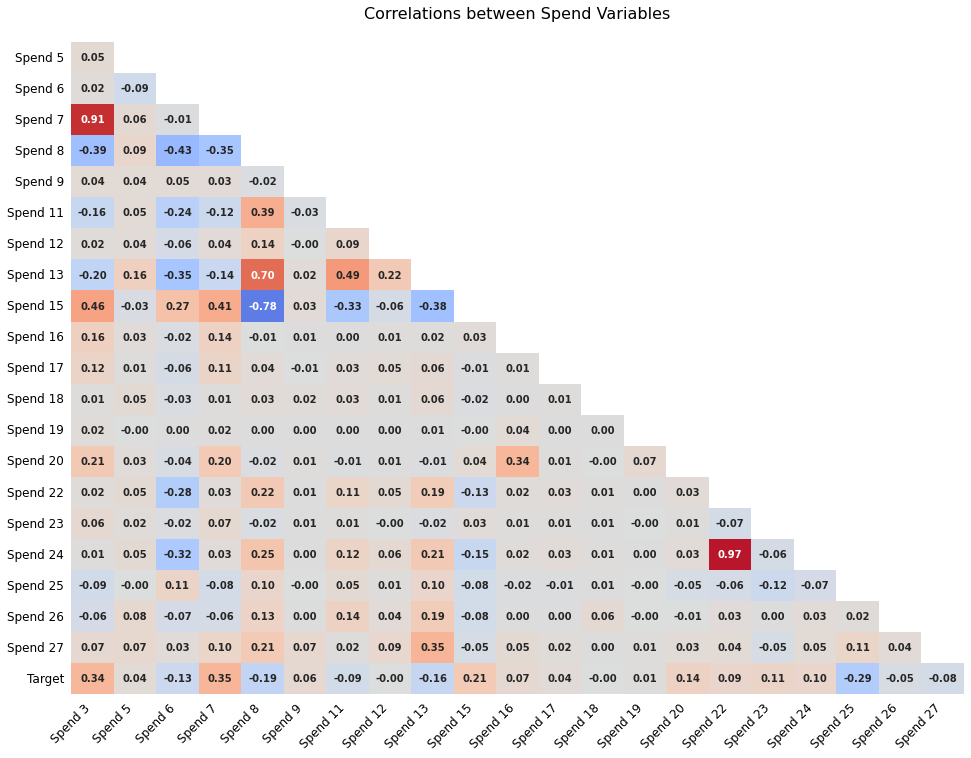

In [9]:
corr = plot_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))[1:, :-1]
corr = corr.iloc[1:, :-1].copy()
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(
    corr,
    mask=mask,
    vmin=-1,
    vmax=1,
    center=0,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    annot_kws={"fontsize": 10, "fontweight": "bold"},
    cbar=False,
)
ax.tick_params(left=False, bottom=False)
ax.set_xticklabels(
    ax.get_xticklabels(), rotation=45, horizontalalignment="right", fontsize=12
)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title("Correlations between Spend Variables\n", fontsize=16)
fig.show()


We observe that `Spend 3` and `Spend 7` are highly positively correlated. `Spend 8` is highly negatively correlated `Spend 13`. It is also highly negatively correlated `Spend 15`. `Spend 22` and `Spend 24` are also highly positively correlated.

#### Distribution of Spend Variables

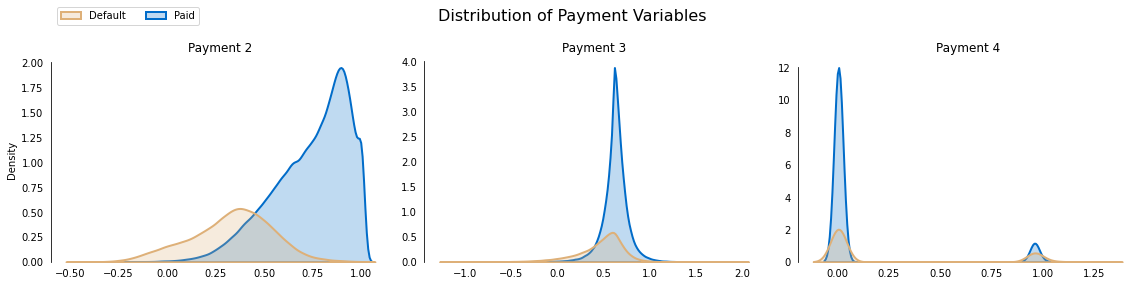

In [11]:
cols = [
    col
    for col in train.columns
    if (col.startswith(("P", "T"))) & (col not in cat_cols[:-1])
]
plot_df = train[cols]
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("Distribution of Payment Variables", fontsize=16)
for i, col in enumerate(plot_df.columns[:-1]):
    sns.kdeplot(
        x=col,
        hue="Target",
        palette=pal[::-1],
        hue_order=[1, 0],
        label=["Default", "Paid"],
        data=plot_df,
        fill=True,
        linewidth=2,
        legend=False,
        ax=ax[i],
    )
    ax[i].tick_params(left=False, bottom=False)
    ax[i].set(title="{}".format(col), xlabel="", ylabel=("Density" if i == 0 else ""))
handles, _ = ax[0].get_legend_handles_labels()
fig.legend(
    labels=["Default", "Paid"],
    handles=reversed(handles),
    ncol=2,
    bbox_to_anchor=(0.18, 1),
)
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])


We notice that `Payment 2` is heavily negatively skewed (left skewed). The other variables seem to have densities clustered around 0 and 1.

#### Correlation of Payment Variables

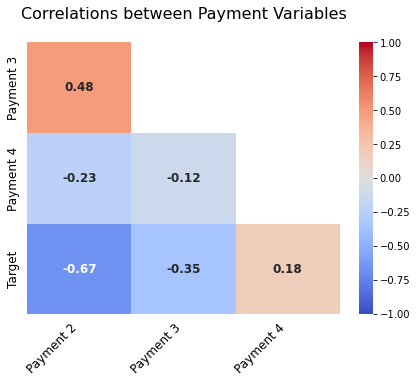

In [12]:
corr = plot_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))[1:, :-1]
corr = corr.iloc[1:, :-1].copy()
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(
    corr,
    mask=mask,
    vmin=-1,
    vmax=1,
    center=0,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    annot_kws={"fontsize": 12, "fontweight": "bold"},
)
ax.tick_params(left=False, bottom=False)
ax.set_xticklabels(
    ax.get_xticklabels(), rotation=45, horizontalalignment="right", fontsize=12
)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title("Correlations between Payment Variables\n", fontsize=16)
fig.show()


We observe that `Payment 2` and `Target` are highly negatively correlated. This could be probably be due to the fact that people paying their bill have a less chance of default.

#### Distribution of Balance Variables

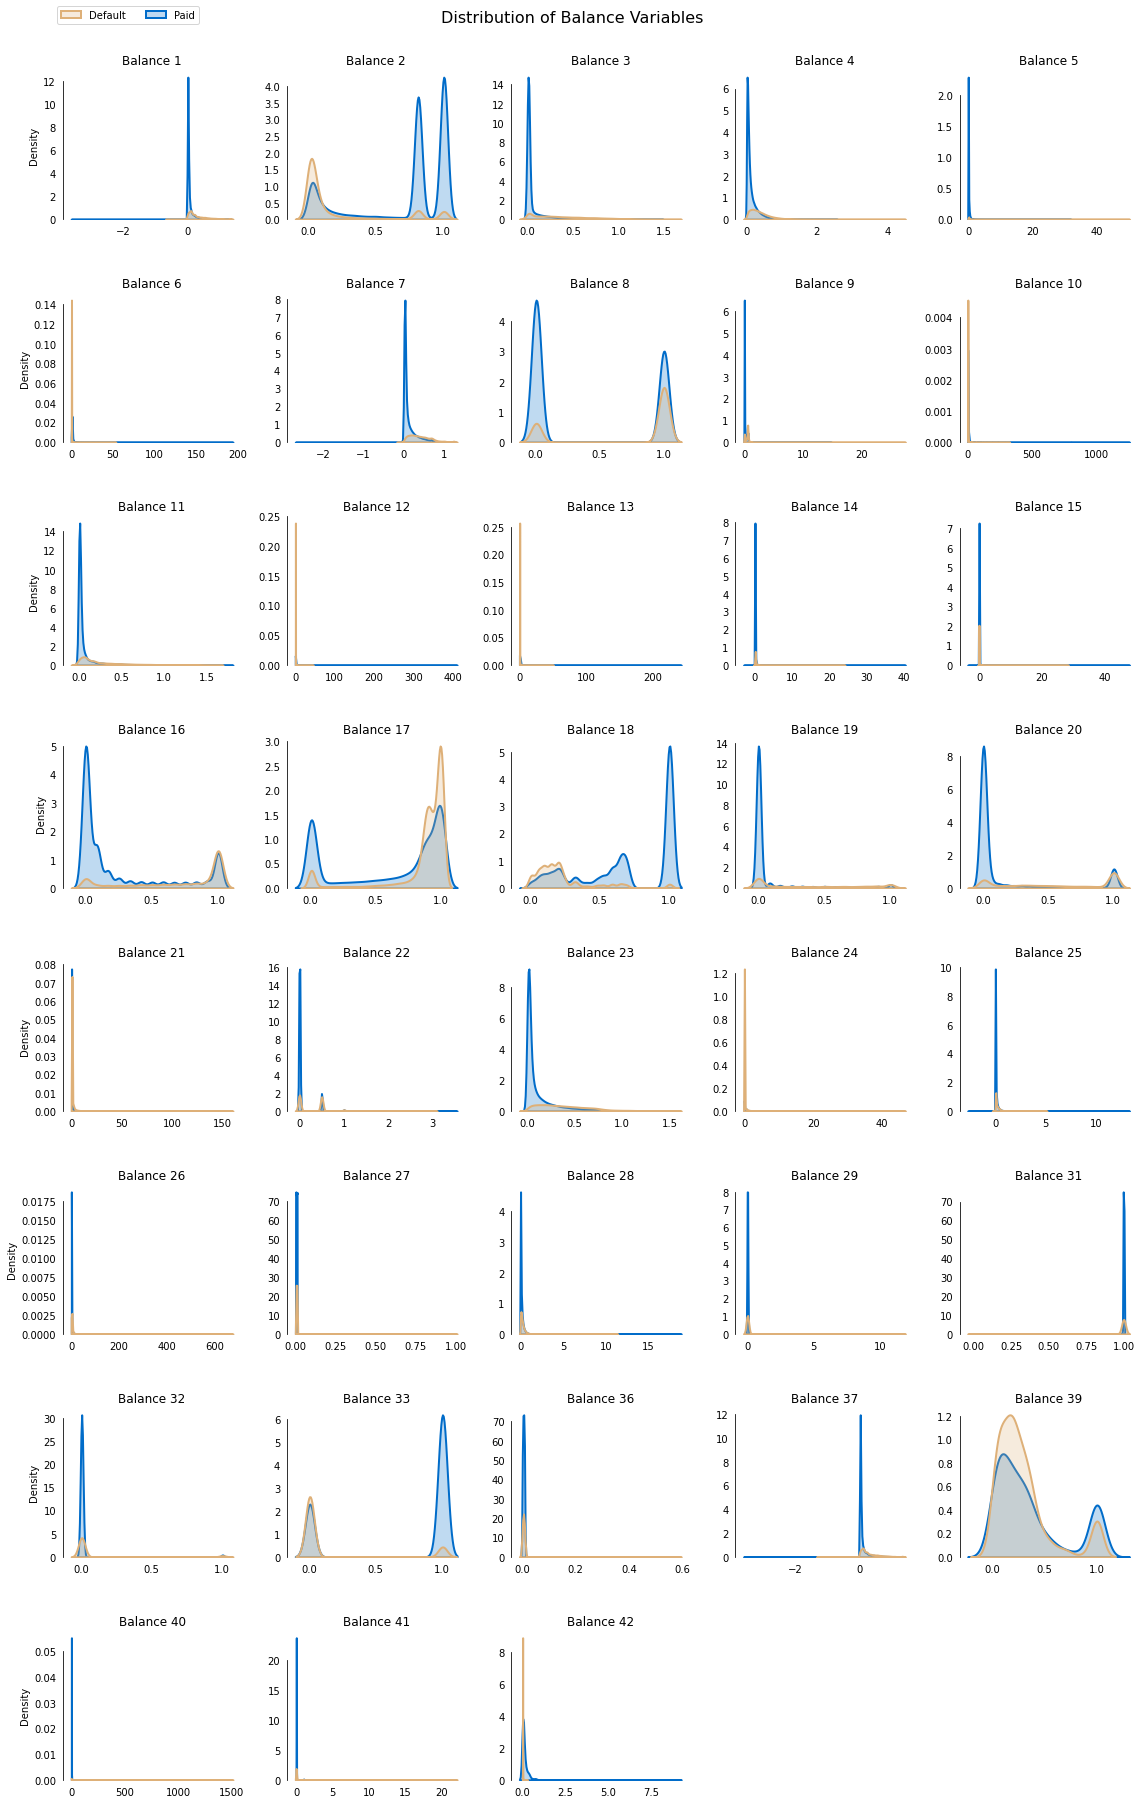

In [14]:
cols = [
    col
    for col in train.columns
    if (col.startswith(("B", "T"))) & (col not in cat_cols[:-1])
]
plot_df = train[cols]
fig, ax = plt.subplots(8, 5, figsize=(16, 32))
fig.suptitle("Distribution of Balance Variables", fontsize=16)
row = 0
col = [0, 1, 2, 3, 4] * 8
for i, column in enumerate(plot_df.columns[:-1]):
    if (i != 0) & (i % 5 == 0):
        row += 1
    sns.kdeplot(
        x=column,
        hue="Target",
        palette=pal[::-1],
        hue_order=[1, 0],
        label=["Default", "Paid"],
        data=plot_df,
        fill=True,
        linewidth=2,
        legend=False,
        ax=ax[row, col[i]],
    )
    ax[row, col[i]].tick_params(left=False, bottom=False)
    ax[row, col[i]].set(
        title="\n\n{}".format(column),
        xlabel="",
        ylabel=("Density" if i % 5 == 0 else ""),
    )
for i in range(3, 5):
    ax[7, i].set_visible(False)
handles, _ = ax[0, 0].get_legend_handles_labels()
fig.legend(
    labels=["Default", "Paid"],
    handles=reversed(handles),
    ncol=2,
    bbox_to_anchor=(0.18, 0.984),
)
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])


#### Correlation of Balance Variables

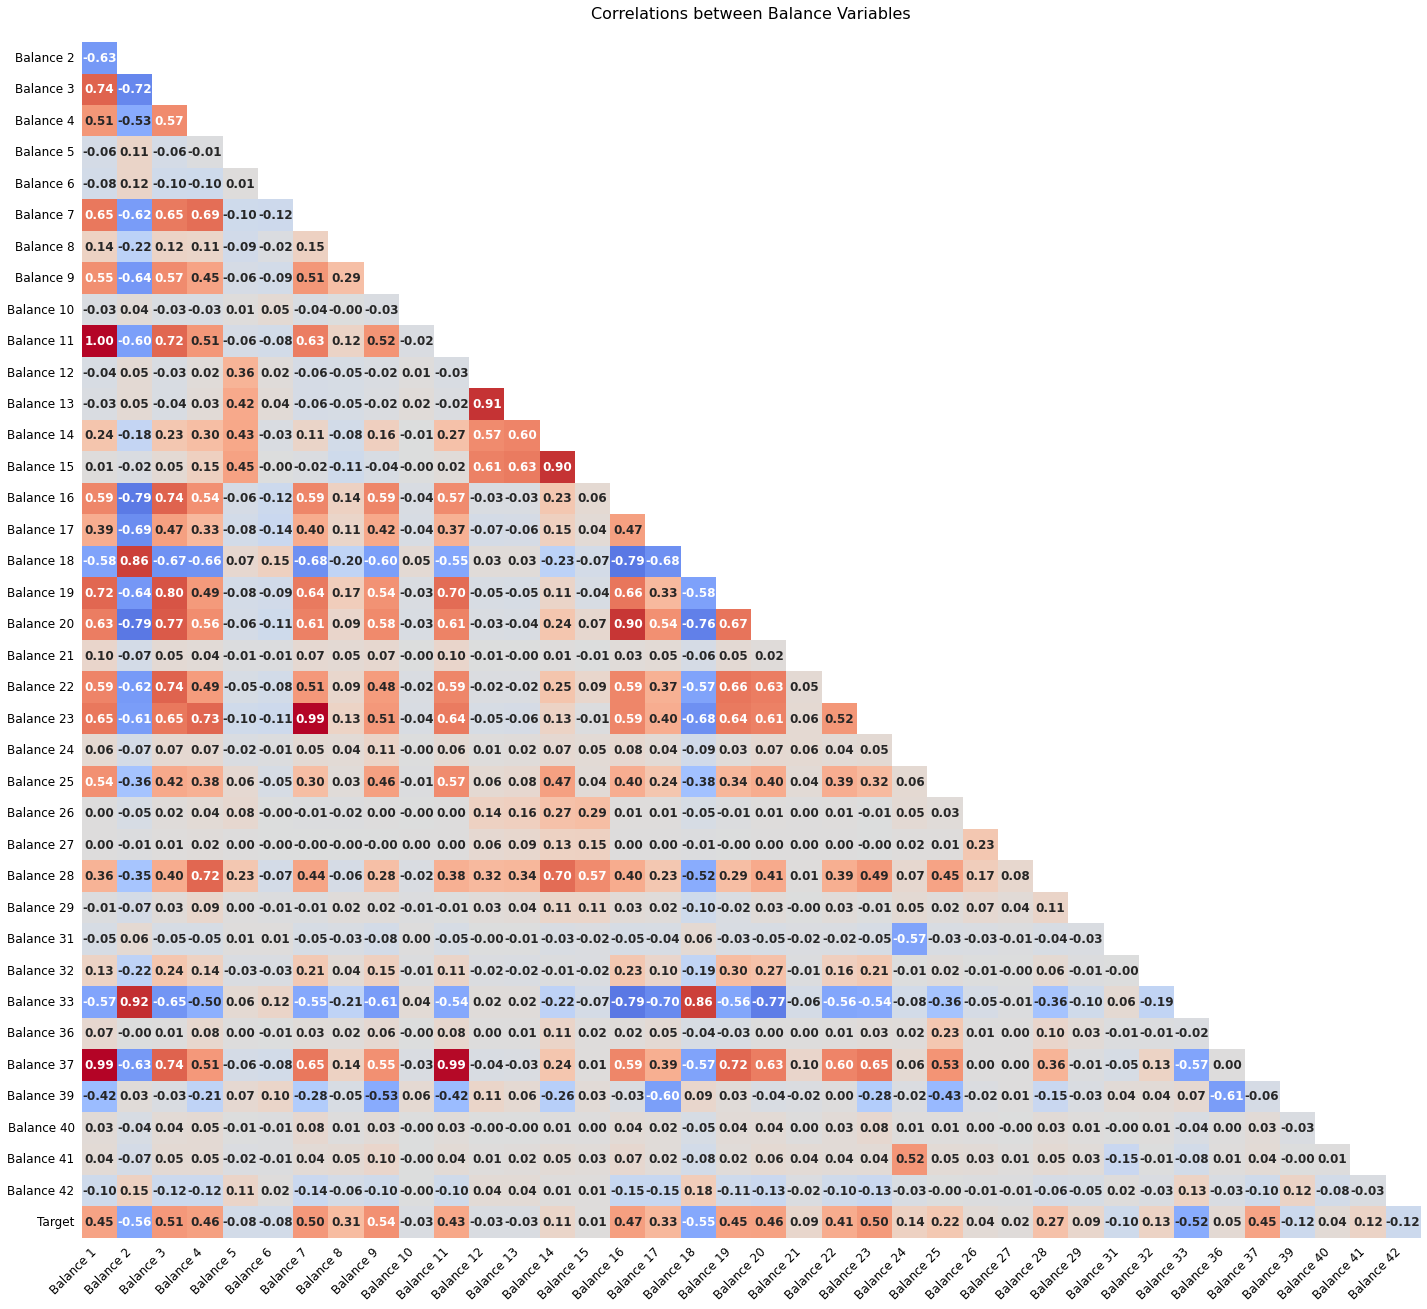

In [15]:
corr = plot_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))[1:, :-1]
corr = corr.iloc[1:, :-1].copy()
fig, ax = plt.subplots(figsize=(24, 22))
sns.heatmap(
    corr,
    mask=mask,
    vmin=-1,
    vmax=1,
    center=0,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    annot_kws={"fontsize": 12, "fontweight": "bold"},
    cbar=False,
)
ax.tick_params(left=False, bottom=False)
ax.set_xticklabels(
    ax.get_xticklabels(), rotation=45, horizontalalignment="right", fontsize=12
)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title("Correlations between Balance Variables\n", fontsize=16)
fig.show()


#### Distribution of Risk Variables

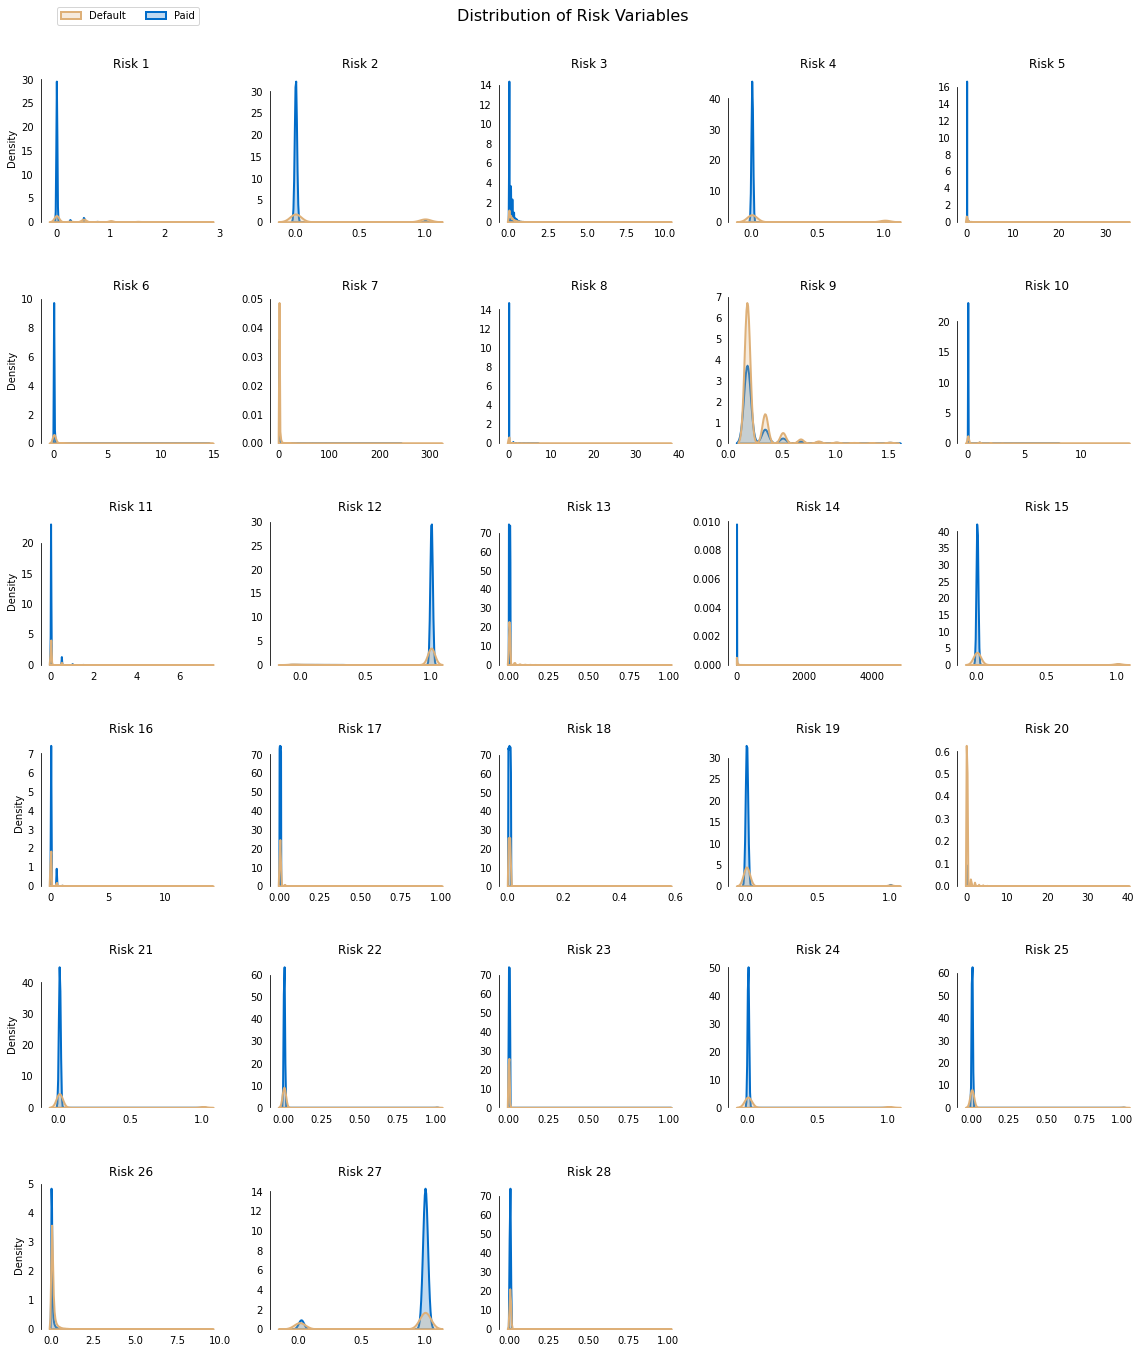

In [17]:
cols = [
    col
    for col in train.columns
    if (col.startswith(("R", "T"))) & (col not in cat_cols[:-1])
]
plot_df = train[cols]
fig, ax = plt.subplots(6, 5, figsize=(16, 24))
fig.suptitle("Distribution of Risk Variables", fontsize=16)
row = 0
col = [0, 1, 2, 3, 4] * 6
for i, column in enumerate(plot_df.columns[:-1]):
    if (i != 0) & (i % 5 == 0):
        row += 1
    sns.kdeplot(
        x=column,
        hue="Target",
        palette=pal[::-1],
        hue_order=[1, 0],
        label=["Default", "Paid"],
        data=plot_df,
        fill=True,
        linewidth=2,
        legend=False,
        ax=ax[row, col[i]],
    )
    ax[row, col[i]].tick_params(left=False, bottom=False)
    ax[row, col[i]].set(
        title="\n\n{}".format(column),
        xlabel="",
        ylabel=("Density" if i % 5 == 0 else ""),
    )
for i in range(3, 5):
    ax[5, i].set_visible(False)
handles, _ = ax[0, 0].get_legend_handles_labels()
fig.legend(
    labels=["Default", "Paid"],
    handles=reversed(handles),
    ncol=2,
    bbox_to_anchor=(0.18, 0.984),
)
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])


#### Correlation of Risk Variables

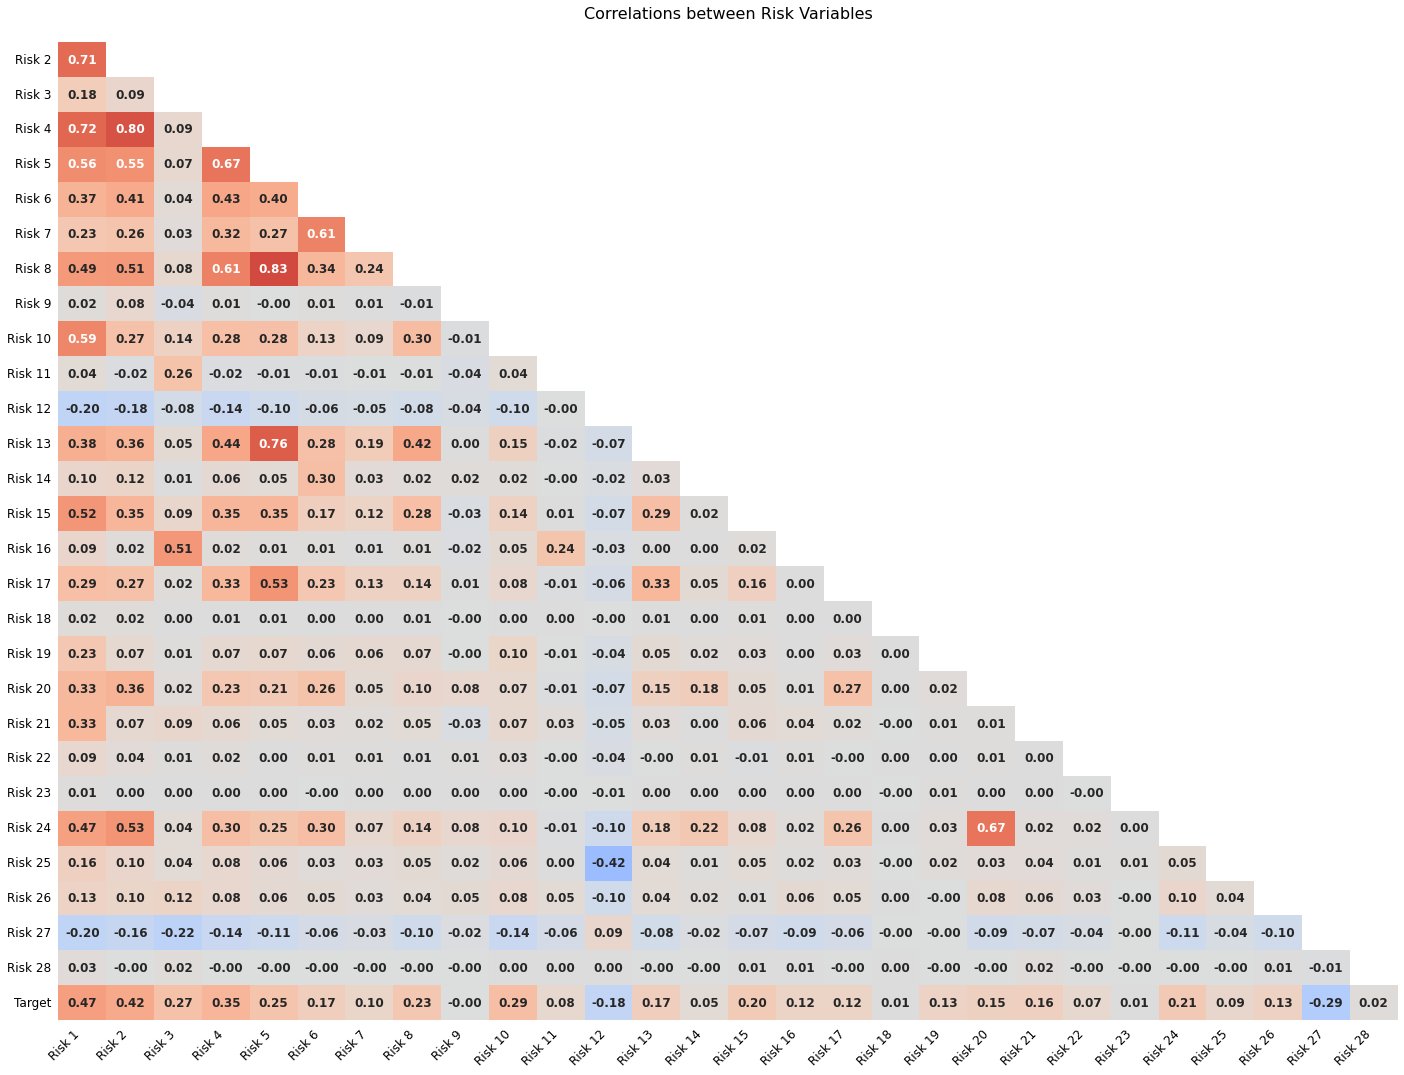

In [18]:
corr = plot_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))[1:, :-1]
corr = corr.iloc[1:, :-1].copy()
fig, ax = plt.subplots(figsize=(24, 18))
sns.heatmap(
    corr,
    mask=mask,
    vmin=-1,
    vmax=1,
    center=0,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    annot_kws={"fontsize": 12, "fontweight": "bold"},
    cbar=False,
)
ax.tick_params(left=False, bottom=False)
ax.set_xticklabels(
    ax.get_xticklabels(), rotation=45, horizontalalignment="right", fontsize=12
)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title("Correlations between Risk Variables\n", fontsize=16)
fig.show()


#### Distribution of Categorical Variables

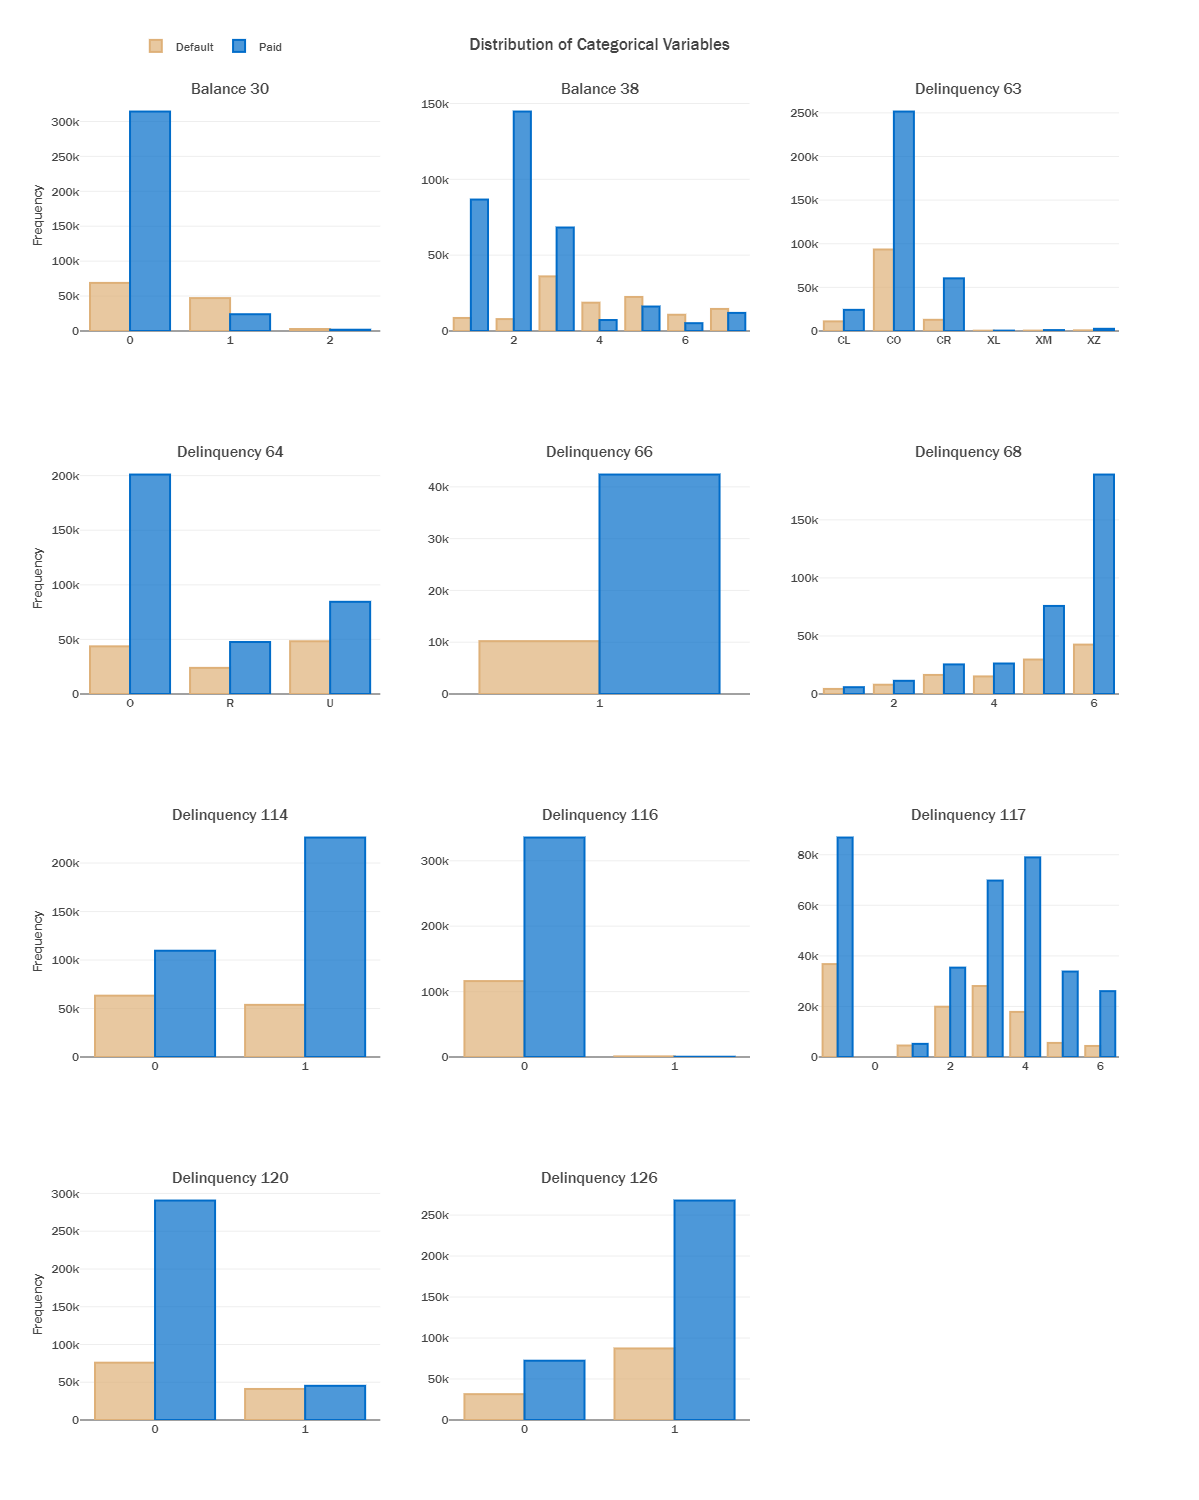

In [20]:
fig = make_subplots(rows=4, cols=3, subplot_titles=cat_cols[:-1], vertical_spacing=0.1)
row = 0
c = [1, 2, 3] * 5
plot_df = train[cat_cols]
for i, col in enumerate(cat_cols[:-1]):
    if i % 3 == 0:
        row += 1
    plot_df[col] = plot_df[col].astype(object)
    df = (
        plot_df.groupby(col)["Target"]
        .value_counts()
        .rename("count")
        .reset_index()
        .replace("", np.nan)
    )

    fig.add_trace(
        go.Bar(
            x=df[df.Target == 1][col],
            y=df[df.Target == 1]["count"],
            marker_color=rgb[1],
            marker_line=dict(color=pal[1], width=2),
            hovertemplate="Value %{x} Frequency = %{y}",
            name="Default",
            showlegend=(True if i == 0 else False),
        ),
        row=row,
        col=c[i],
    )
    fig.add_trace(
        go.Bar(
            x=df[df.Target == 0][col],
            y=df[df.Target == 0]["count"],
            marker_color=rgb[0],
            marker_line=dict(color=pal[0], width=2),
            hovertemplate="Value %{x} Frequency = %{y}",
            name="Paid",
            showlegend=(True if i == 0 else False),
        ),
        row=row,
        col=c[i],
    )
    if i % 3 == 0:
        fig.update_yaxes(title="Frequency", row=row, col=c[i])
fig.update_layout(
    template=temp,
    title="Distribution of Categorical Variables",
    legend=dict(orientation="h", yanchor="bottom", y=1.03, xanchor="right", x=0.2),
    barmode="group",
    height=1500,
    width=900,
)
fig.show()
